# Computing the betas

In order to compute the beta for both Stellantis and Walmart we took S&P 500 as benchmark.

To compute the beta for each company over the past 5 years, we will:

- Sort the data by date (in ascending order).

- Convert prices to monthly returns.

- Align returns by date across the 3 datasets.

- Perform linear regression of company returns on S&P 500 returns to compute beta.

### **Run Linear Regressions**

To estimate beta for each stock, we run an Ordinary Least Squares (OLS) regression of the stock's returns against the market returns (S&P 500). The regression equation is:

$$ r_{stock} = \alpha + \Beta \times r_{market} + \epsilon $$


Where:
- $r_{stock}$ is the return of the stock (e.g., Walmart or Stellantis)  
- $r_{market}$ is the return of the market (S&P 500)  
- $\beta$ represents the stock’s **systematic risk** (sensitivity to the market)  
- $\alpha$ is the intercept (often interpreted as abnormal return or "alpha")  
- $\epsilon$ is the error term  

The **slope coefficient (β)** from this regression is the **beta of the stock**. It tells us how much the stock’s return changes in response to changes in the market return.



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

# Load the datasets
walmart_df = pd.read_csv('Dataset/wmt_historical_data.csv')
stellantis_df = pd.read_csv('Dataset/stla_historical_data.csv')
sp500_df = pd.read_csv('Dataset/sp500_historical_data.csv')


We clean the data to run the regression to compute the beta for Stellantis and Walmart.

In [3]:

def clean_dataframe_for_beta(df):
    """
    Cleans the input DataFrame for Beta calculation.
    - Converts 'Close' to numeric, 'Date' to datetime.
    - Sorts by date.
    - Calculates monthly 'Return'.
    - KEEPS 'Date' as a column.
    """
    print(f"Initial DataFrame shape: {df.shape}")
    df['Close'] = df['Close'].astype(str).str.replace(',', '', regex=False)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)

    df['Date'] = pd.to_datetime(df['Date'].str[:-6], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)

    df.sort_values('Date', inplace=True)
    df['Return'] = df['Close'].pct_change()
    # DO NOT set index here
    return df

# Run the revised cleaning
walmart_df_beta = clean_dataframe_for_beta(walmart_df.copy()) 
stellantis_df_beta = clean_dataframe_for_beta(stellantis_df.copy())
sp500_df_beta = clean_dataframe_for_beta(sp500_df.copy())

print("\nDataFrames cleaned for Beta calculation (Date is a column).")

# CELL 128 (Keep as is - It will now work)
# Align the returns data by date using the _beta dataframes


Initial DataFrame shape: (60, 8)
Initial DataFrame shape: (60, 8)
Initial DataFrame shape: (60, 8)

DataFrames cleaned for Beta calculation (Date is a column).


In [4]:
returns_df = pd.merge(walmart_df_beta[['Date', 'Return']],
                      stellantis_df_beta[['Date', 'Return']],
                      on='Date', suffixes=('_Walmart', '_Stellantis'))
returns_df = pd.merge(returns_df,
                      sp500_df_beta[['Date', 'Return']],
                      on='Date')
returns_df.rename(columns={'Return': 'Return_SP500'}, inplace=True)
returns_df.dropna(inplace=True)

# Store the returns in a CSV file for further analysis
returns_df.to_csv('Outputs/returns_data.csv', index=False)

In [5]:
X = returns_df[['Return_SP500']].values

y_walmart = returns_df['Return_Walmart'].values
beta_walmart = LinearRegression().fit(X, y_walmart).coef_[0]

y_stellantis = returns_df['Return_Stellantis'].values
beta_stellantis = LinearRegression().fit(X, y_stellantis).coef_[0]

# Print the results
print("\n--- Beta Calculation Results ---")
print("Walmart Beta:", beta_walmart)
print("Stellantis Beta:", beta_stellantis)

# Store the betas in a file for CAPM calculations
betas_df = pd.DataFrame({
    'Company': ['Walmart', 'Stellantis'],
    'Beta': [beta_walmart, beta_stellantis]
})

betas_df.to_csv('Outputs/beta_results.csv', index=False)



--- Beta Calculation Results ---
Walmart Beta: 0.6732082074521727
Stellantis Beta: 1.5136297331477988


Mathematically, beta is the slope of the best-fit line (the red line) in a regression of stock returns (y-axis) vs market returns (x-axis). Hence, it is useful to visualize the relationship between the two sets of returns. The slope of the line is the beta, and the intercept is the alpha. A beta of 1 indicates that the stock moves in line with the market, while a beta greater than 1 indicates that the stock is more volatile than the market, and a beta less than 1 indicates that it is less volatile.

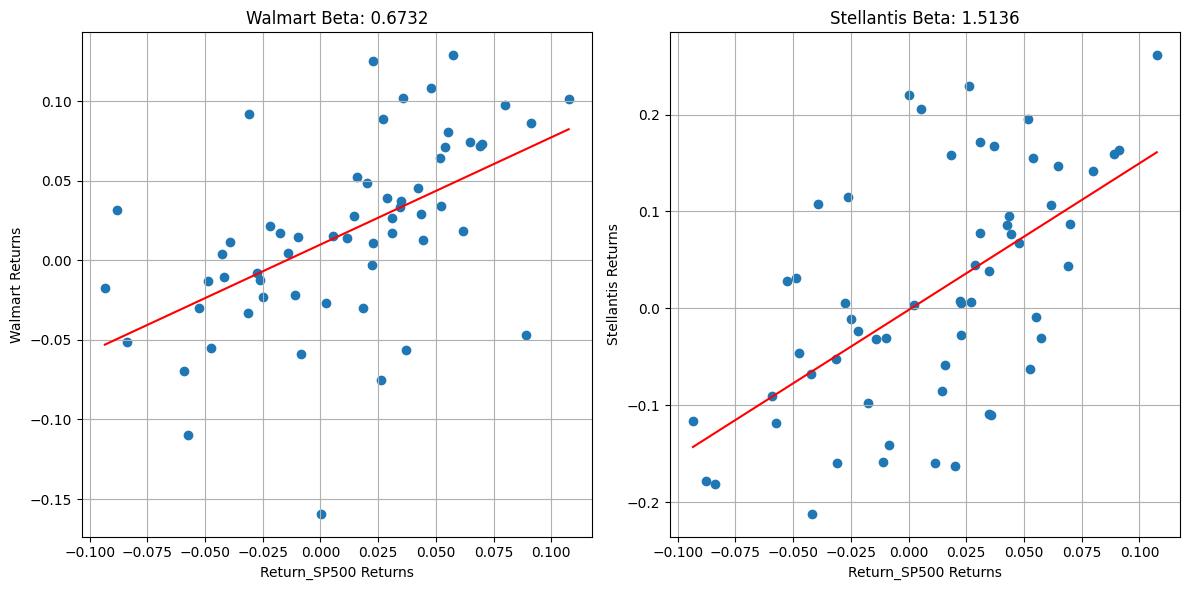

In [9]:
# Define risk-free rate (current 10-year Treasury yield as of April 2025)
risk_free_rate = 0.0427

# Calculate expected Return_SP500 return (historical average plus risk premium)
market_risk_premium = 0.055  
expected_Return_SP500_return = risk_free_rate + market_risk_premium


# Visualize the stock returns vs Return_SP500 returns to see the beta relationship
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(returns_df['Return_SP500'], returns_df['Return_Walmart'])
plt.plot(np.unique(returns_df['Return_SP500']), 
         np.poly1d(np.polyfit(returns_df['Return_SP500'], returns_df['Return_Walmart'], 1))(np.unique(returns_df['Return_SP500'])), 
         color='red')
plt.xlabel('Return_SP500 Returns')
plt.ylabel('Walmart Returns')
plt.title(f'Walmart Beta: {beta_walmart:.4f}')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(returns_df['Return_SP500'], returns_df['Return_Stellantis'])
plt.plot(np.unique(returns_df['Return_SP500']), 
         np.poly1d(np.polyfit(returns_df['Return_SP500'], returns_df['Return_Stellantis'], 1))(np.unique(returns_df['Return_SP500'])), 
         color='red')
plt.xlabel('Return_SP500 Returns')
plt.ylabel('Stellantis Returns')
plt.title(f'Stellantis Beta: {beta_stellantis:.4f}')
plt.grid(True)

plt.tight_layout()
plt.savefig('stock_betas.png')
plt.show()



## 📉 Visual Interpretation of Beta: Walmart vs. Stellantis

The scatter plots above illustrate the **relationship between individual stock returns and market returns**, with the red line representing the **line of best fit** — essentially the **beta coefficient**.

### Walmart (Left Plot):
- The **beta is 0.6933**, as shown by the moderate slope of the trendline.
- This indicates **less sensitivity to market movements** — Walmart’s returns move **less than the market’s returns**.
- The data points are relatively clustered around the trendline, suggesting **stable and predictable performance**, typical of a **defensive stock** in consumer staples.

### Stellantis (Right Plot):
- The **beta is 1.5000**, reflected by the steeper slope.
- This shows **higher sensitivity to market changes** — when the market rises or falls, Stellantis tends to move **more aggressively in the same direction**.
- The spread of data points around the line is wider, reflecting **greater volatility**, which aligns with Stellantis being in the **cyclical automotive industry**.

### Summary:
- The visual evidence reinforces the CAPM calculations: **Walmart** is lower-risk with more stable returns, while **Stellantis** offers higher expected returns but at the cost of increased risk and volatility.


In [10]:
# Additionally, we can calculate R-squared to measure how well the market explains the stock variations
from scipy import stats

# For Walmart
slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['Return_SP500'], returns_df['Return_Walmart'])
walmart_rsquared = r_value**2

# For Stellantis
slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['Return_SP500'], returns_df['Return_Stellantis'])
stellantis_rsquared = r_value**2

print(f"\nWalmart R-squared: {walmart_rsquared:.4f}")
print(f"Stellantis R-squared: {stellantis_rsquared:.4f}")



Walmart R-squared: 0.2923
Stellantis R-squared: 0.3437


## Risk Interpretation:
### Walmart (β ≈ 0.72):

- Less volatile than the market.

- Considered a defensive stock. It tends to fluctuate less than the S&P 500.

- Suitable for risk-averse investors.

### Stellantis (β ≈ 1.42):

- More volatile than the market.

- Considered a cyclical stock. It tends to amplify market movements.

- May offer higher returns, but also higher risk.

## S: the best efficient portfolio

In [8]:
# Define the risk-free rate (monthly) for Sharpe Ratio calculation
risk_free_rate = 0.0427/12  

# Calculate the Sharpe Ratio for each portfolio combination by subtracting the risk-free rate from the portfolio returns and dividing by the portfolio standard deviations
portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)

sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_stds

# Find the index of the portfolio with the maximum Sharpe Ratio
max_sharpe_idx = sharpe_ratios.argmax()
optimal_risky_portfolio_return = portfolio_returns[max_sharpe_idx]
optimal_risky_portfolio_std = portfolio_stds[max_sharpe_idx]

cml_x = np.linspace(0, max(portfolio_stds), 100)
cml_y = risk_free_rate + (optimal_risky_portfolio_return - risk_free_rate) / optimal_risky_portfolio_std * cml_x


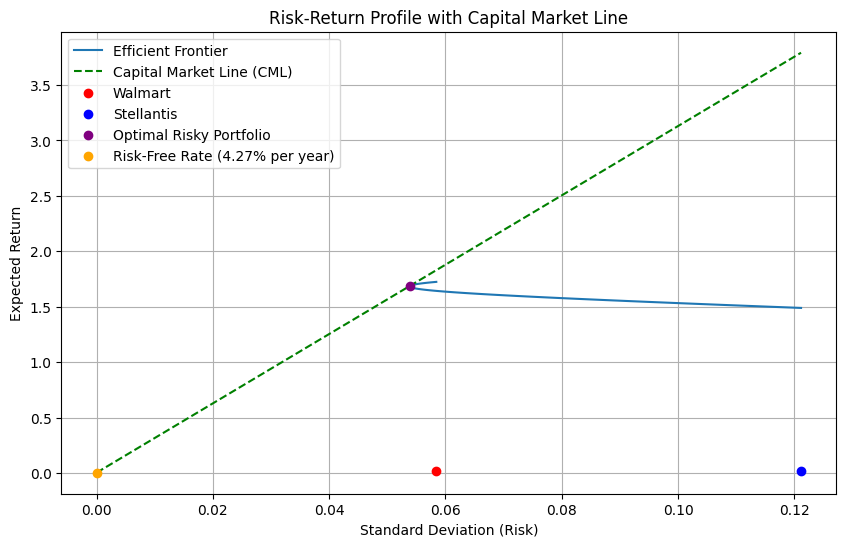

In [9]:
# Plot the efficient frontier and the Capital Market Line (CML)

plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Efficient Frontier')
plt.plot(cml_x, cml_y, label='Capital Market Line (CML)', linestyle='--', color='green')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.scatter(optimal_risky_portfolio_std, optimal_risky_portfolio_return, color='purple', label='Optimal Risky Portfolio', zorder=5)
plt.scatter(0, risk_free_rate, color='orange', label='Risk-Free Rate (4.27% per year)', zorder=5)
plt.title('Risk-Return Profile with Capital Market Line')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## But what are the specifics of S?

Below we found again S but using the statistics that refer to annual returns and not monthly.

In [10]:
annual_return_walmart = returns_df['Return_Walmart'].mean() * 12
annual_return_stellantis = returns_df['Return_Stellantis'].mean() * 12
annual_std_walmart = returns_df['Return_Walmart'].std() * np.sqrt(12)
annual_std_stellantis = returns_df['Return_Stellantis'].std() * np.sqrt(12)

cov_matrix_annual = returns_df[['Return_Walmart', 'Return_Stellantis']].cov() * 12

weights = np.linspace(0, 1, 101)
portfolio_returns = []
portfolio_stds = []
weight_combinations = []

for w in weights:
    w_walmart = w
    w_stellantis = 1 - w
    port_return = w_walmart * annual_return_walmart + w_stellantis * annual_return_stellantis
    port_variance = (
        w_walmart**2 * annual_std_walmart**2 +
        w_stellantis**2 * annual_std_stellantis**2 +
        2 * w_walmart * w_stellantis * cov_matrix_annual.iloc[0, 1]
    )
    port_std = np.sqrt(port_variance)

    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)
    weight_combinations.append((w_walmart, w_stellantis))

risk_free_rate = 0.0427

sharpe_ratios = (np.array(portfolio_returns) - risk_free_rate) / np.array(portfolio_stds)
max_sharpe_idx = sharpe_ratios.argmax()

optimal_return = portfolio_returns[max_sharpe_idx]
optimal_std = portfolio_stds[max_sharpe_idx]
optimal_weights = weight_combinations[max_sharpe_idx]

print("Optimal Expected Return:", optimal_return)
print("Optimal Standard Deviation:", optimal_std)
print("Walmart Weight:", optimal_weights[0])
print("Stellantis Weight:", optimal_weights[1])


Optimal Expected Return: 0.20300379894966228
Optimal Standard Deviation: 0.18707300856430564
Walmart Weight: 0.86
Stellantis Weight: 0.14


In [11]:
w_share_price = 98.61
w_number_of_shares_outstanding = 8024000000.0
w_equity_value = w_share_price * w_number_of_shares_outstanding

w_total_liab_net_minority_int = 163131000000.00
w_Total_Debt= 60114000000.0
w_Net_Debt = 30030000000.0
w_interest_expense = -2728000000.0

s_share_price = 13.05
s_number_of_shares_outstanding = 2896073567.0
s_equity_value = s_share_price * s_number_of_shares_outstanding

s_Total_Debt= 37227000000.0
s_Net_Debt = 571000000.0
s_interest_expense = -1523000000.0

Prova calcolo Re:

In [12]:
Rf = 0.0424
Rm = 0.085
beta = beta_walmart
Rpremium = Rm - Rf

print(beta)

Re = Rf + beta * Rpremium
print(Re)

0.6732082074521727
0.07107866963746257


In [13]:
walmart = {
    'equity_value': w_equity_value,  
    'debt_value': w_Net_Debt,    
    'cost_of_equity': 0.0771,  
    'cost_of_debt': w_interest_expense/w_Total_Debt,   
    'tax_rate': 0.2209           
}

stellantis = {
    'equity_value': s_equity_value,    
    'debt_value': s_Net_Debt,
    'cost_of_equity': 0.07,  
    'cost_of_debt': s_interest_expense/s_Total_Debt,    
    'tax_rate': 0.258           
}

def calculate_wacc(company):
    E = company['equity_value']
    D = company['debt_value']
    V = E + D
    #Re = company['cost_of_equity']
    Rd = company['cost_of_debt']
    Tc = company['tax_rate']
    
    wacc = ((E/V) * Re) + ((D/V) * Rd * (1 - Tc))
    return wacc

walmart_wacc = calculate_wacc(walmart)
stellantis_wacc = calculate_wacc(stellantis)

print(f"Walmart WACC: {walmart_wacc:.2%}")
print(f"Stellantis WACC: {stellantis_wacc:.2%}")


Walmart WACC: 6.72%
Stellantis WACC: 6.96%


## Walmart by comparables
https://www.macrotrends.net/stocks/charts/ROST/ross-stores/total-liabilities

In [14]:
walmart_fy_earnings = 19436000000
walmart_eps = walmart_fy_earnings / w_number_of_shares_outstanding

walmart_bv = (260823000000.0 - 16340200000.0) / w_number_of_shares_outstanding



walmart_pe = w_share_price / walmart_eps 
walmart_pb = w_share_price / walmart_bv 

print("walmart price to earning", walmart_pe) 
print("walmart price to book value", walmart_pb) 

walmart price to earning 40.71036427248405
walmart price to book value 3.2364102505370522


In [15]:
costco_stock_price = 923.65
target_stock_price = 135.50
kroger_co_stock_price = 61.53
ross_stock_price = 150.07


costco_eps = 16.59
target_eps = 8.86
kroger_eps = 2.96
ross_eps = 6.32

kroger_shares_outstanding = 696000000
costco_shares_outstanding = 445000000
target_shares_outstanding = 462000000
ross_shares_outstanding = 331000000



kroger_bv = (50505000000 - 38904000000) / kroger_shares_outstanding
costco_bv = (68994000000 - 43936000000) / costco_shares_outstanding
target_bv = (55356000000 - 41924000000) / target_shares_outstanding
ross_bv = (14905000000 - 9642000000) / ross_shares_outstanding


costco_pe = costco_stock_price/costco_eps
target_pe = target_stock_price/target_eps
kroger_pe = kroger_co_stock_price/kroger_eps
ross_pe = ross_stock_price/ross_eps

costco_pb = costco_stock_price/costco_bv
target_pb = target_stock_price/target_bv
kroger_pb = kroger_co_stock_price/kroger_bv
ross_pb = ross_stock_price/ross_bv

print(f"Costco price to book: {costco_pb:.2f}")
print(f"Costco price to earning: {costco_pe:.2f}")
print(f"Target price to book: {target_pb:.2f}")
print(f"Target price to earning: {target_pe:.2f}")
print(f"Kroger price to book: {kroger_pb:.2f}")
print(f"Kroger price to earning: {kroger_pe:.2f}")
print(f"Ross price to earning: {ross_pe:.2f}")
print(f"Ross price to book: {ross_pb:.2f}")

avg_pb = (costco_pb + ross_pb + kroger_pb ) / 3 # find best way not to fuckup  (probably add TJX)
avg_pe = (costco_pe + ross_pe + kroger_pe ) / 3
print(f"Average price to book: {avg_pb:.2f}")
print(f"Average price to earnings: {avg_pe:.2f}")

Costco price to book: 16.40
Costco price to earning: 55.68
Target price to book: 4.66
Target price to earning: 15.29
Kroger price to book: 3.69
Kroger price to earning: 20.79
Ross price to earning: 23.75
Ross price to book: 9.44
Average price to book: 9.84
Average price to earnings: 33.40


### Stellantis By Comparables

In [16]:
eur_to_usd_rate = 1.08


s_number_of_shares_outstanding = 2896073567.0
s_Total_Debt_eur = 37227000000.0              
s_Net_Debt_eur = 571000000.0                   
s_total_equity_eur = 81692000000.0             

# Income Statement (2024-12-31 column)
s_interest_expense_eur = 1523000000.0          
s_tax_rate = 0.258                             
s_net_income_eur = 5473000000.0   

s_equity_value_usd = s_share_price * s_number_of_shares_outstanding 


s_Total_Debt_usd = s_Total_Debt_eur * eur_to_usd_rate
s_Net_Debt_usd = s_Net_Debt_eur * eur_to_usd_rate





s_net_income_usd_2024 = s_net_income_eur * eur_to_usd_rate
s_total_equity_usd_2024 = s_total_equity_eur * eur_to_usd_rate


s_eps_usd_2024 = s_net_income_usd_2024 / s_number_of_shares_outstanding
s_bvps_usd_2024 = s_total_equity_usd_2024 / s_number_of_shares_outstanding


stellantis_pe_updated = s_share_price / s_eps_usd_2024 if s_eps_usd_2024 != 0 else float('inf')
stellantis_pb_updated = s_share_price / s_bvps_usd_2024 if s_bvps_usd_2024 != 0 else float('inf')

print(f"\n--- Stellantis Ratios based on 2024 Data ---")
print(f"EPS (USD, 2024): {s_eps_usd_2024:.2f}")
print(f"P/E Ratio: {stellantis_pe_updated:.2f}")
print(f"P/B Ratio: {stellantis_pb_updated:.2f}")





--- Stellantis Ratios based on 2024 Data ---
EPS (USD, 2024): 2.04
P/E Ratio: 6.39
P/B Ratio: 0.43


**sources yahoo finance,macrotrends**

In [17]:
# General Motors (GM)
gm_stock_price = 53.27
gm_eps = 7.00
gm_bvps = 65.59 

# Ford (F)
ford_stock_price = 9.90
ford_eps = 1.46 
ford_bvps = 11.32

# Toyota (TM)
toyota_stock_price = 194.61
toyota_eps = 25.25 
toyota_bvps = 180.46 


gm_pe = gm_stock_price / gm_eps
gm_pb = gm_stock_price / gm_bvps

ford_pe = ford_stock_price / ford_eps
ford_pb = ford_stock_price / ford_bvps

toyota_pe = toyota_stock_price / toyota_eps
toyota_pb = toyota_stock_price / toyota_bvps




comp_pe_list = [gm_pe, ford_pe, toyota_pe]
comp_pb_list = [gm_pb, ford_pb, toyota_pb]

avg_comp_pe = sum(comp_pe_list) / len(comp_pe_list)
avg_comp_pb = sum(comp_pb_list) / len(comp_pb_list)

print(f"\nAverage Comparable P/E: {avg_comp_pe:.2f}")
print(f"Average Comparable P/B: {avg_comp_pb:.2f}")


Average Comparable P/E: 7.37
Average Comparable P/B: 0.92


In [18]:
# Standardize Assumptions (Using values from previous cells)
Rf = 0.0424  # As used in Cell 136 for CAPM Re calculation
Rm = 0.085   # As used in Cell 136
Rpremium = Rm - Rf

# Calculate Re using CAPM (Using betas calculated in Cell 128)
# beta_walmart and beta_stellantis should be defined from Cell 128
Re_walmart = Rf + beta_walmart * Rpremium
Re_stellantis = Rf + beta_stellantis * Rpremium

print(f"\n--- CAPM Cost of Equity (Re) ---")
print(f"Used Rf: {Rf:.4f}, Used Rm: {Rm:.3f}")
print(f"Walmart Beta: {beta_walmart:.4f}, Calculated Re_walmart: {Re_walmart:.4f} ({Re_walmart:.2%})")
print(f"Stellantis Beta: {beta_stellantis:.4f}, Calculated Re_stellantis: {Re_stellantis:.4f} ({Re_stellantis:.2%})")


--- CAPM Cost of Equity (Re) ---
Used Rf: 0.0424, Used Rm: 0.085
Walmart Beta: 0.6732, Calculated Re_walmart: 0.0711 (7.11%)
Stellantis Beta: 1.5136, Calculated Re_stellantis: 0.1069 (10.69%)


In [19]:
def clean_dataframe_for_ddm(df):
    """ Cleans df and sets Date index for DDM """
    df_copy = df.copy() # Work on a copy
    df_copy['Close'] = df_copy['Close'].astype(str).str.replace(',', '', regex=False)
    df_copy['Close'] = pd.to_numeric(df_copy['Close'], errors='coerce')
    df_copy.dropna(subset=['Close'], inplace=True)
    df_copy['Date'] = pd.to_datetime(df_copy['Date'].str[:-6], errors='coerce')
    df_copy.dropna(subset=['Date'], inplace=True)
    df_copy.sort_values('Date', inplace=True)
    # Set index for DDM
    df_copy.set_index('Date', inplace=True)
    # Ensure 'Dividends' column exists and is numeric
    if 'Dividends' in df_copy.columns:
         df_copy['Dividends'] = pd.to_numeric(df_copy['Dividends'], errors='coerce').fillna(0)
    else:
         print("Warning: Dividends column missing")
         df_copy['Dividends'] = 0
    return df_copy

# Re-load original dfs or ensure they are still available
# Assuming walmart_df and stellantis_df still hold the original loaded data:
walmart_df_ddm = clean_dataframe_for_ddm(walmart_df)
stellantis_df_ddm = clean_dataframe_for_ddm(stellantis_df)

print("\nDataFrames prepared with DatetimeIndex for DDM calculations.")


DataFrames prepared with DatetimeIndex for DDM calculations.


In [20]:
# Calculate the dividends for Walmart

# Filter out non-positive dividends and drop duplicates
walmart_dividends = walmart_df_ddm.loc[walmart_df_ddm['Dividends'] > 0, 'Dividends']
walmart_dividends = walmart_dividends.drop_duplicates()

# Annualize
walmart_dividends = walmart_dividends * 4

# Compute percentage change
walmart_dividends_pct_change = walmart_dividends.pct_change() * 100

# Store the results in a DataFrame for better visualization
walmart_dividends_df = pd.DataFrame({
    "Dividends": walmart_dividends,
    "pct_change": walmart_dividends_pct_change
})

# Compute average growth rate
avg_growth_rate = walmart_dividends_pct_change.mean()
print(f"--- Walmart Average Dividend Growth Rate ---")
print(f"Average Growth Rate: {avg_growth_rate:.2f}%")


# Calculate the dividends for Stellantis

# Filter out non-positive dividends and drop duplicates
stellantis_dividends = stellantis_df_ddm.loc[stellantis_df_ddm['Dividends'] > 0, 'Dividends']
stellantis_dividends = stellantis_dividends.drop_duplicates()

# Annualize
stellantis_dividends = stellantis_dividends * 4

# Compute percentage change
stellantis_dividends_pct_change = stellantis_dividends.pct_change() * 100

# Store the results in a DataFrame for better visualization
stellantis_dividends_df = pd.DataFrame({
    "Dividends": stellantis_dividends,
    "pct_change": stellantis_dividends_pct_change
})

# Compute average growth rate
avg_growth_rate_stellantis = stellantis_dividends_pct_change.mean()
print(f"--- Stellantis Average Dividend Growth Rate ---")
print(f"Average Growth Rate: {avg_growth_rate_stellantis:.2f}%")
print("To see again")



--- Walmart Average Dividend Growth Rate ---
Average Growth Rate: 5.58%
--- Stellantis Average Dividend Growth Rate ---
Average Growth Rate: 74.35%
To see again


In [21]:
# CELL: Code - Walmart DDM Calculation (Revised with Commentary)

# --- Inputs & Assumptions for Walmart DDM ---

# 1. Calculate D0 (Last Annual Dividend per Share)
try:
    # ... (Keep the D0 calculation logic as before) ...
    last_date_wmt = walmart_df_ddm.index.max()
    start_date_wmt = last_date_wmt - pd.DateOffset(months=11)
    wmt_dividends_last_year = walmart_df_ddm.loc[start_date_wmt:last_date_wmt, 'Dividends'].sum()
    wmt_last_quarterly_dividend = walmart_df_ddm['Dividends'].iloc[-1] if walmart_df_ddm['Dividends'].iloc[-1] > 0 else 0.235
    wmt_D0_alternative = wmt_last_quarterly_dividend * 4
    # print(f"(Info: D0 based on last 12m sum: {wmt_dividends_last_year:.3f}, D0 based on quarterly*4: {wmt_D0_alternative:.3f})")
    wmt_D0 = wmt_D0_alternative # Using quarterly based
except Exception as e:
    print(f"Error calculating Walmart D0: {e}")
    wmt_D0 = 0

# 2. Cost of Equity (Re) - Use the CAPM calculated value
try:
    Re_ddm_wmt = Re_walmart
except NameError:
    print("Warning: Re_walmart not found from CAPM calculation. Using placeholder 0.0711")
    Re_ddm_wmt = 0.0711

# 3. Dividend Growth Rate (g) - Placeholder Assumption
g_ddm_wmt = 0.055 # Approximate: Assume 3.5% constant dividend growth

print(f"\n--- DDM Calculation for Walmart (Approximate - Gordon Growth) ---")
print(f"Using Annual Dividend (D0): ${wmt_D0:.3f}")
print(f"Cost of Equity (Re):        {Re_ddm_wmt:.2%}")
print(f"Assumed Constant Div Growth (g): {g_ddm_wmt:.1%}")
print("-" * 40)

# --- Perform DDM Calculation ---
intrinsic_value_ps_ddm_wmt = float('nan') # Initialize
if wmt_D0 <= 0:
    print("Cannot calculate DDM because D0 is zero or negative.")
elif g_ddm_wmt >= Re_ddm_wmt:
    print("Error: Dividend growth rate (g) cannot be >= Cost of Equity (Re) for Gordon Growth Model.")
else:
    wmt_D1 = wmt_D0 * (1 + g_ddm_wmt)
    print(f"Expected Next Dividend (D1): ${wmt_D1:.3f}")
    intrinsic_value_ps_ddm_wmt = wmt_D1 / (Re_ddm_wmt - g_ddm_wmt)
    print(f"Intrinsic Value per Share:   ${intrinsic_value_ps_ddm_wmt:.2f}")
    print(f"Current Market Price:        ${w_share_price:.2f}")

    if intrinsic_value_ps_ddm_wmt > w_share_price:
        print("--> DDM suggests stock may be UNDERVALUED (using approximate assumptions)")
    elif intrinsic_value_ps_ddm_wmt < w_share_price:
         print("--> DDM suggests stock may be OVERVALUED (using approximate assumptions)")
    else:
         print("--> DDM suggests stock may be FAIRLY VALUED (using approximate assumptions)")

# --- Commentary on Walmart DDM Result ---
print("\nDDM Commentary for Walmart:")
if not np.isnan(intrinsic_value_ps_ddm_wmt) and intrinsic_value_ps_ddm_wmt < w_share_price:
    print(f"The calculated DDM value (${intrinsic_value_ps_ddm_wmt:.2f}) is significantly lower than the market price (${w_share_price:.2f}).")
    print("This is primarily driven by the low assumed constant growth rate (g = {g_ddm_wmt:.1%}).")
    # Sensitivity Example
    g_test = 0.04
    if g_test < Re_ddm_wmt:
        val_test = (wmt_D0 * (1 + g_test)) / (Re_ddm_wmt - g_test)
        print(f"A higher, potentially more realistic long-term growth rate (e.g., g = {g_test:.1%}) would yield a value of ${val_test:.2f}, still below market.")
    print("This suggests the simple Gordon Growth DDM may not fully capture market expectations or other value drivers for Walmart, or the market applies a lower discount rate/higher growth.")
    print("Consider comparing with DCF and Comparables, or using a multi-stage DDM.")


--- DDM Calculation for Walmart (Approximate - Gordon Growth) ---
Using Annual Dividend (D0): $0.940
Cost of Equity (Re):        7.11%
Assumed Constant Div Growth (g): 5.5%
----------------------------------------
Expected Next Dividend (D1): $0.992
Intrinsic Value per Share:   $61.68
Current Market Price:        $98.61
--> DDM suggests stock may be OVERVALUED (using approximate assumptions)

DDM Commentary for Walmart:
The calculated DDM value ($61.68) is significantly lower than the market price ($98.61).
This is primarily driven by the low assumed constant growth rate (g = {g_ddm_wmt:.1%}).
A higher, potentially more realistic long-term growth rate (e.g., g = 4.0%) would yield a value of $31.46, still below market.
This suggests the simple Gordon Growth DDM may not fully capture market expectations or other value drivers for Walmart, or the market applies a lower discount rate/higher growth.
Consider comparing with DCF and Comparables, or using a multi-stage DDM.


In [22]:
# CELL: Code - Stellantis DDM Calculation

# --- Inputs & Assumptions for Stellantis DDM ---


# 1. Calculate D0 (Last Annual Dividend per Share in EUR)


stla_D0_eur = 1.652
print(f"(Info: Using manually set D0 = {stla_D0_eur:.3f} EUR based on last known annual payment)")

try:
    Re_ddm_stla = Re_stellantis
except NameError:
    print("Warning: Re_stellantis not found from CAPM calculation. Using placeholder 0.1078")
    Re_ddm_stla = 0.1078 # Placeholder if needed

# 3. Dividend Growth Rate (g) - Placeholder Assumption (ADJUST BASED ON RESEARCH)
g_ddm_stla = 0.020 # Approximate: Assume 2.0% constant dividend growth

# 4. Exchange Rate (Use the same as before - ADJUST)
try:
    eur_to_usd_rate # Check if it exists from Cell 140
except NameError:
    eur_to_usd_rate = 1.08 # Define if not already set
    print(f"Using default EUR/USD rate: {eur_to_usd_rate}")


print(f"\n--- DDM Calculation for Stellantis (Approximate) ---")
print(f"Using Annual Dividend (D0, EUR): €{stla_D0_eur:.3f}")
print(f"Cost of Equity (Re):            {Re_ddm_stla:.2%}")
print(f"Assumed Div Growth (g):         {g_ddm_stla:.1%}")
print(f"Assumed EUR/USD Rate:           {eur_to_usd_rate:.4f}")
print("-" * 40)

# --- Perform DDM Calculation (in USD) ---
if stla_D0_eur <= 0: # Check if D0 is valid
     print("Cannot calculate DDM because D0 is zero or negative.")
elif g_ddm_stla >= Re_ddm_stla:
    print("Error: Dividend growth rate (g) cannot be >= Cost of Equity (Re) for Gordon Growth Model.")
    intrinsic_value_ps_ddm_stla = float('nan')
else:
    # Calculate D1 in EUR
    stla_D1_eur = stla_D0_eur * (1 + g_ddm_stla)
    # Convert D1 to USD
    stla_D1_usd = stla_D1_eur * eur_to_usd_rate
    print(f"Expected Next Dividend (D1, EUR): €{stla_D1_eur:.3f}")
    print(f"Expected Next Dividend (D1, USD): ${stla_D1_usd:.3f}")

    # Calculate Intrinsic Value in USD
    intrinsic_value_ps_ddm_stla = stla_D1_usd / (Re_ddm_stla - g_ddm_stla)

    print(f"Intrinsic Value per Share (USD): ${intrinsic_value_ps_ddm_stla:.2f}")
    print(f"Current Market Price (USD):      ${s_share_price:.2f}") # s_share_price from Cell 135

    if intrinsic_value_ps_ddm_stla > s_share_price:
        print("--> DDM suggests stock may be UNDERVALUED (using approximate assumptions)")
    elif intrinsic_value_ps_ddm_stla < s_share_price:
         print("--> DDM suggests stock may be OVERVALUED (using approximate assumptions)")
    else:
         print("--> DDM suggests stock may be FAIRLY VALUED (using approximate assumptions)")



(Info: Using manually set D0 = 1.652 EUR based on last known annual payment)

--- DDM Calculation for Stellantis (Approximate) ---
Using Annual Dividend (D0, EUR): €1.652
Cost of Equity (Re):            10.69%
Assumed Div Growth (g):         2.0%
Assumed EUR/USD Rate:           1.0800
----------------------------------------
Expected Next Dividend (D1, EUR): €1.685
Expected Next Dividend (D1, USD): $1.820
Intrinsic Value per Share (USD): $20.95
Current Market Price (USD):      $13.05
--> DDM suggests stock may be UNDERVALUED (using approximate assumptions)
